In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import wrangle
import split_scale
import env

from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
df = wrangle.wrangle_telco().set_index("customer_id")
X = df.loc[:, ("tenure", "monthly_charges")]
y = pd.DataFrame(df.total_charges)

In [4]:
df.head()

,tenure,monthly_charges,total_charges
customer_id,,,
0013-SMEOE,71,109.70,7904.25
0014-BMAQU,63,84.65,5377.80
0016-QLJIS,65,90.45,5957.90
0017-DINOC,54,45.20,2460.55
0017-IUDMW,72,116.80,8456.75


In [8]:
# split into train & test
train,test=split_scale.split_my_data(df)
# use standard scaler to scale all data, this step fit and scale
scaler,train_sc,test_sc=split_scale.perform_standard_scaler(train,test)

In [9]:
train_sc.describe() #std scaler scaled the spread of distributions for all var

,tenure,monthly_charges,total_charges
count,1.348000e+03,1.348000e+03,1.348000e+03
mean,-4.513370e-17,1.047629e-16,3.887428e-17
std,1.000371e+00,1.000371e+00,1.000371e+00
min,-3.226512e+00,-1.223843e+00,-1.447170e+00
25%,-4.745646e-01,-1.065902e+00,-9.582201e-01
50%,3.854189e-01,1.001273e-01,-2.270583e-03
75%,7.867446e-01,8.567334e-01,8.741470e-01
max,8.440768e-01,1.664427e+00,1.918537e+00


In [10]:
# split into Xy_unscaled data
X_train = train.drop(columns = 'total_charges')
y_train = train.total_charges
X_test = test.drop(columns = 'total_charges')
y_test = test.total_charges

In [11]:
# split into Xy_scaled data
X_train_sc = train_sc.drop(columns = "total_charges")
y_train_sc = train_sc[["total_charges"]]
X_test_sc = test_sc.drop(columns = "total_charges")
y_test_sc = test_sc[["total_charges"]]

In [109]:
feature_nonscale, p_val_nonscale = select_kbest_freg(X_train, y_train, 2) 
feature_nonscale, p_val_nonscale

(['tenure', 'monthly_charges'], array([2.8954156e-150, 0.0000000e+000]))

In [110]:
feature_scaled, p_val_scaled = select_kbest_freg(X_train_sc, y_train_sc, 2) 
feature_scaled, p_val_scaled

(['tenure', 'monthly_charges'], array([2.8954156e-150, 0.0000000e+000]))

In [17]:
present_kbest = pd.DataFrame(np.array(["1st Feature", "1st p-value", "2nd Feature", "2nd p-value"]), columns=['metric']).set_index("metric")
present_kbest["unscaled"] = np.array([feature_nonscale[0], p_val_nonscale[0], feature_nonscale[1], p_val_nonscale[1]])
present_kbest['scaled'] = np.array([feature_scaled[0], p_val_scaled[0], feature_scaled[1], p_val_scaled[1]])
present_kbest

,unscaled,scaled
metric,,
1st Feature,tenure,tenure
1st p-value,2.895415602153489e-150,2.895415602152008e-150
2nd Feature,monthly_charges,monthly_charges
2nd p-value,0.0,0.0


In [114]:
back_elim = ols_backward_elimination(X_train_sc, y_train_sc)
back_elim

['tenure', 'monthly_charges']

In [117]:
feature = lasso_cv_coef(X_train_sc, y_train_sc)
feature

monthly_charges    0.825586
tenure             0.287812
dtype: float64

In [107]:
n = find_optimum(X_train, y_train)
selected_features = find_feature_name(X_train, y_train, n)
result = recursive_feature_elimination(selected_features, n)
print(selected_features)
print(result)

Index(['tenure', 'monthly_charges'], dtype='object')
tenure             True
monthly_charges    True
dtype: bool


In [111]:
def select_kbest_freg(X_train, y_train, k): 
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression

    f_selector = SelectKBest(f_regression, k).fit(X_train,y_train)
    
    #f_support return T/F for select feature or not
    f_support = f_selector.get_support()
    
    # f_feature return the selected features
    f_feature = X_train.loc[:,f_support].columns.tolist()

    return f_feature

In [115]:
# perform backward_elimination provide ols as model
# return stats summary and selected feature
def ols_backward_elimination(X_train, y_train):
    
    import statsmodels.api as sm
    
    # loop over each (X_train) columns, 
    # find relationship between the particular var and target
    cols = list(X_train.columns)
    #pmax = 1
    while (len(cols)>0):
        # store p-value
        # take in the column name when looped over
        X_1 = X_train[cols]
        #X_1 = sm.add_constant(X_1)
        # extract all info for OLS summary table, name and p-val
        model = sm.OLS(y_train,X_1).fit()
        p = model.pvalues
        #p = pd.Series(model.pvalues.values[1:],index = cols)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break

    selected_features_BE = cols    
    return selected_features_BE

In [116]:
def lasso_cv_coef(X_train, y_train): 
    from sklearn.linear_model import LassoCV
    import matplotlib

    reg = LassoCV().fit(X_train, y_train)

    coef = pd.Series(reg.coef_, index = X_train.columns).sort_values(ascending = False)

#     matplotlib.rcParams['figure.figsize'] = (4.0, 5.0)
#     imp_coef.plot(kind = "barh")
#     plt.title("Feature importance using Lasso Model")

    return coef

In [119]:
find_optimum(X_train, y_train)

2

In [5]:
def optimal_number_of_features(X_train, y_train): 
    from sklearn.linear_model import LinearRegression
    from sklearn.feature_selection import RFE

    features_range = range(1, len(X_train.columns) +1 )
    # set high score to be the lowest
    high_score = 0
    #Variable to store the optimum features
    number_of_features = 0
    score_list = []

    for n in features_range:
        model = LinearRegression() # use model to generate performance metrics
        train_rfe  = RFE(model, n).fit_transform(X_train, y_train) # fit_transform to RFE
        model.fit(train_rfe, y_train) # fit to LinearRegression
        score = model.score(train_rfe, y_train)
        score_list.append(score)
        if (score>high_score):
            high_score = score
            number_of_features = n 
    return number_of_features

In [14]:
number_of_features = optimal_number_of_features(X_train, y_train)

In [23]:
def RFE_feature_name(X_train, y_train, X_test, number_of_features):
    from sklearn.linear_model import LinearRegression
    from sklearn.feature_selection import RFE

    cols = list(X_train.columns)
    model = LinearRegression()
    
    rfe = RFE(model, number_of_features)
    
    train_rfe = rfe.fit_transform(X_train, y_train)
    test_rfe = rfe.transform(X_test)
    
    model.fit(train_rfe, y_train)
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp == True].index
    
    X_train_rfe = pd.DataFrame(train_rfe, columns = selected_features_rfe)
    X_test_rfe = pd.DataFrame(test_rfe, columns = selected_features_rfe)
    
    return selected_features_rfe, X_train_rfe, X_test_rfe

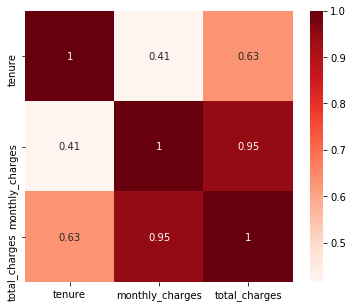

In [7]:
plt.figure(figsize=(6,5))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [8]:
df.describe()

,tenure,monthly_charges,total_charges
count,1685.00000,1685.000000,1685.000000
mean,57.07181,60.872374,3728.933947
std,17.72913,34.712210,2571.252806
min,1.00000,18.400000,20.350000
25%,48.00000,24.050000,1278.800000
50%,64.00000,64.450000,3623.950000
75%,71.00000,90.550000,5999.850000
max,72.00000,118.750000,8672.450000


In [9]:
def perform_standard_scaler(train, test):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(train)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, test_scaled


sc, train_sc, test_sc = perform_standard_scaler(train, test)

In [10]:
def perform_uniform_scaler(train, test):
    u_scaler = QuantileTransformer(n_quantiles=100, output_distribution='uniform', random_state=123, copy=True).fit(train)
    u_train_scaled = pd.DataFrame(u_scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    u_test_scaled = pd.DataFrame(u_scaler.transform(test), columns=test.columns.values).set_index([test.index.values])

    return u_scaler, u_train_scaled, u_test_scaled
scu, train_scu, test_scu = perform_uniform_scaler(train, test)

In [11]:
def gaussian_scaler(train, test):
    p_scaler = PowerTransformer(method='yeo-johnson', standardize=False, copy=True).fit(train)
    p_train_scaled = pd.DataFrame(p_scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    p_test_scaled = pd.DataFrame(p_scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return p_scaler, p_train_scaled, p_test_scaled
scg, train_scg, test_scg = gaussian_scaler(train, test)

In [12]:
def min_max_scaler(train, test):
	mm_scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(train)
	mm_train_scaled = pd.DataFrame(mm_scaler.transform(train), columns= train.columns.values).set_index([train.index.values])
	mm_test_scaled = pd.DataFrame(mm_scaler.transform(test), columns= test.columns.values).set_index([test.index.values])
	return mm_scaler, mm_train_scaled, mm_test_scaled
scmm, train_scmm, test_scmm = min_max_scaler(train, test)

In [13]:
def iqr_robust_scaler(train, test):
    r_scaler = RobustScaler(quantile_range=(25.0,75.0), copy=True, with_centering=True, with_scaling=True).fit(train)
    r_train_scaled = pd.DataFrame(r_scaler.transform(train), columns= train.columns.values).set_index([train.index.values])
    r_test_scaled = pd.DataFrame(r_scaler.transform(test), columns= test.columns.values).set_index([test.index.values])
    return r_scaler, r_train_scaled, r_test_scaled
scr, train_scr, test_scr = iqr_robust_scaler(train, test)

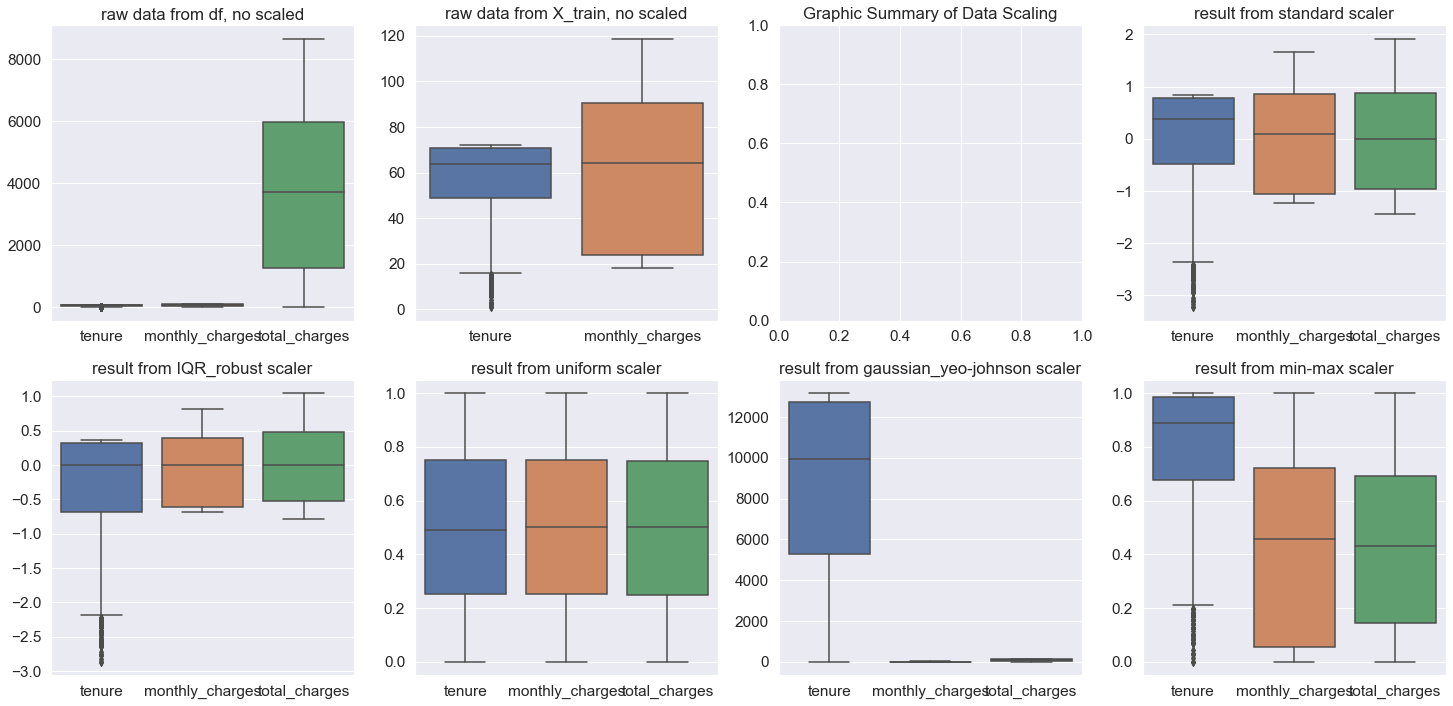

In [14]:
from matplotlib import gridspec

fig = plt.figure(figsize=(25, 25))
gs = gridspec.GridSpec(4, 4)
sns.set(font_scale=1.4)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 3])
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[1, 2])
ax6 = plt.subplot(gs[1, 3])
ax7 = plt.subplot(gs[1, 0])
ax8 = plt.subplot(gs[0, 2])


ax1.set_title("raw data from df, no scaled")
ax2.set_title("raw data from X_train, no scaled")
ax3.set_title("result from standard scaler")
ax4.set_title("result from uniform scaler")
ax5.set_title("result from gaussian_yeo-johnson scaler")
ax6.set_title("result from min-max scaler")
ax7.set_title("result from IQR_robust scaler")
ax8.set_title("Graphic Summary of Data Scaling")

sns.boxplot(data=train, ax = ax1)
sns.boxplot(data=X_train, ax = ax2)
sns.boxplot(data=train_sc, ax = ax3)
sns.boxplot(data = train_scu, ax = ax4)
sns.boxplot(data = train_scg, ax = ax5)
sns.boxplot(data = train_scmm, ax = ax6)
sns.boxplot(data = train_scr, ax = ax7)



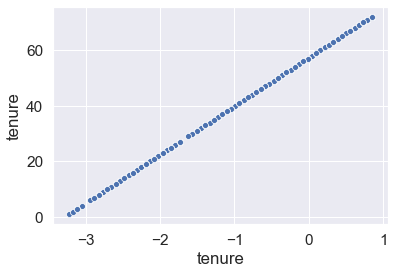

In [15]:
sns.scatterplot(x = train_sc.tenure, y = train.tenure)

In [16]:
train_scu.head()

,tenure,monthly_charges,total_charges
0707-HOVVN,0.686869,0.580710,0.657682
8380-MQINP,0.323232,0.181818,0.181987
2307-FYNNL,0.515152,0.898309,0.872947
6797-LNAQX,0.686869,0.800304,0.850193
8879-XUAHX,0.752525,0.987325,0.995336


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import pandas as pd
import numpy as np

In [41]:
def optimal_features(X_train, y_train, number_of_features):
    '''Taking the output of optimal_number_of_features, as n, and use that value to 
    run recursive feature elimination to find the n best features'''
    cols = list(X_train.columns)
    model = LinearRegression()
    
    #Initializing RFE model
    rfe = RFE(model, number_of_features)

    #Transforming data using RFE
    X_rfe = rfe.fit_transform(X_train,y_train)  

    #Fitting the data to model
    model.fit(X_rfe,y_train)
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    
    return selected_features_rfe

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()

#Initializing RFE model, with parameter to select top 2 features. 
rfe = RFE(model, 2)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_sc,y_train_sc)  

#Fitting the data to model
model.fit(X_rfe,y_train_sc)

print("rfe_support: ", rfe.support_)
print("rfe.ranking: ", '   ', rfe.ranking_)

rfe_support:  [ True  True]
rfe.ranking:      [1 1]


RMSE <= $5

don't scale your y